<a href="https://colab.research.google.com/github/gauravpks/dl-repo/blob/master/RNN/Encoder_Decoder_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sklearn
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.random.set_seed(42)

In [4]:
import os
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR


In [7]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [8]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [9]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9ELY8P/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9ELY8P/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9ELY8P/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Epoch 1/5
781/781 [==============================] - 6s 6ms/step - loss: 0.5861 - accuracy: 0.6919
Epoch 2/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5181 - accuracy: 0.7445
Epoch 3/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5122 - accuracy: 0.7494
Epoch 4/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5086 - accuracy: 0.7496
Epoch 5/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5054 - accuracy: 0.7520


**Encoder-Decoder Network**

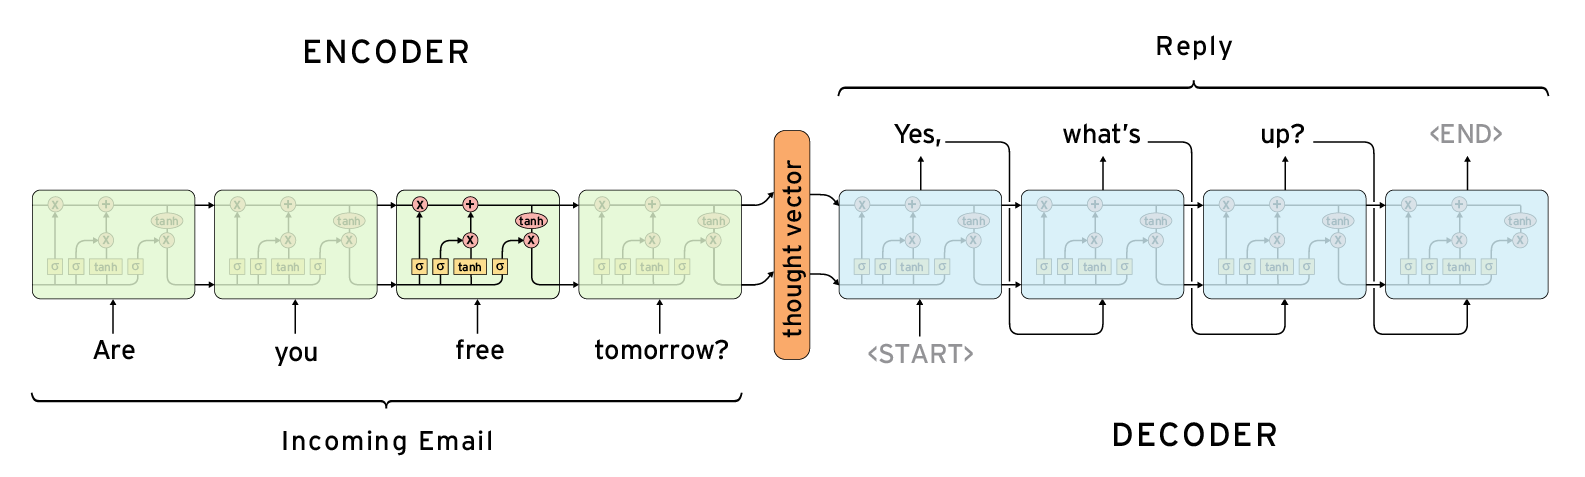

In [10]:
tf.random.set_seed(42)

In [11]:
vocab_size = 100
embed_size = 10

In [13]:
!pip install tensorflow_addons


     |████████████████████████████████| 706kB 5.2MB/s 


In [15]:
import tensorflow_addons as tfa
import numpy as np


encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [17]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 16s 371ms/step - loss: 4.6055
Epoch 2/2
32/32 [==============================] - 12s 366ms/step - loss: 4.6027
